In [1]:
import copy
import numpy as np
import scipy
import sys
import py2tex.py2tex as py2tex
import verdict
import os

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
import matplotlib.cm as cm
import matplotlib.colors as plt_colors
import matplotlib.gridspec as gridspec
import palettable

In [3]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as worldline_set
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [4]:
import galaxy_dive.analyze_data.ahf as analyze_ahf
import galaxy_dive.plot_data.ahf as plot_ahf
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.executable_helpers as exec_helpers

In [5]:
import linefinder.utils.file_management as file_management
import linefinder.config as config

# Load Data

In [6]:
sim_name = 'm12i_md'
sim_names = [
    'm12i_md',
    'm12b_md',
    'm12m',
    'm12f',
]
snum = 600

In [7]:
galdef = ''

In [8]:
file_manager = file_management.FileManager( 'hot_halo_physics' )

In [9]:
defaults = file_manager.get_linefinder_analysis_defaults(
    '_hothaloacc',
    sim_name = sim_name,
    galdef = galdef
)

In [10]:
ind = defaults['ahf_index'] - snum

In [12]:
w = w_set[sim_name].data_object

In [13]:
w.retrieve_halo_data()

Attribute retrieve_halo_data not found in plotting object. Checking data object.


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [14]:
print( w.tag )

Attribute tag not found in plotting object. Checking data object.
m12i_md_hothaloacc


In [15]:
m_plot_label  = r'$M_{\rm h} = 10^{' + '{:.02g}'.format( np.log10( w.m_vir[snum] ) )
m_plot_label += '} M_\odot$'
plot_label = m_plot_label + ', z={:.02}'.format( w.redshift[snum] )
print( plot_label )

Attribute m_vir not found in plotting object. Checking data object.
Attribute redshift not found in plotting object. Checking data object.
$M_{\rm h} = 10^{12} M_\odot$, z=0.0


In [16]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )

In [17]:
w_plotter = p_worldlines.WorldlinesPlotter( w, label=plot_label )

# Calculate $\theta$
Also called $\phi$...

In [57]:
for sim_name_j, w_j in w_set.items():
    
    print( 'Calculating angular momentum for {}'.format( sim_name_j ) )
    
    s_data = particle_data.ParticleData(
        sdir = file_manager.get_sim_dir( sim_name_j ),
        snum = snum,
        ptype = config.PTYPE_STAR,
        halo_data_dir = file_manager.get_halo_dir( sim_name_j ),
        main_halo_id = config.MAIN_MT_HALO_ID[sim_name_j],    
    )
    
    w_j.data_object.calc_abs_phi( normal_vector=s_data.total_ang_momentum )

Calculating angular momentum for m12i_md
Attribute calc_abs_phi not found in plotting object. Checking data object.


Calculating angular momentum for m12b_md
Attribute calc_abs_phi not found in plotting object. Checking data object.


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


Calculating angular momentum for m12m
Attribute calc_abs_phi not found in plotting object. Checking data object.
Calculating angular momentum for m12f
Attribute calc_abs_phi not found in plotting object. Checking data object.


# Hot Mode Accretion Investigation

In [20]:
# Setup axes
t_window = 1.
t = w.get_data( 'time' )
x_range = [ t[ind] - t_window, t[ind] ]

Attribute get_data not found in plotting object. Checking data object.


In [21]:
t_snaps = t[( t > x_range[0] ) & ( t < x_range[1] )][::-1]

In [22]:
n_snaps = t_snaps.size

In [23]:
dt = t_snaps[1:] - t_snaps[:-1]

In [24]:
t_bins = np.zeros( ( t_snaps.size + 1, ) )
t_bins[1:-1] = t_snaps[:-1] + dt / 2.
t_bins[0] = t_snaps[0] - dt[0] / 2.
t_bins[-1] = t_snaps[-1] + dt[-1] / 2.

## Distribution Plots

Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_data not found in plotting object. Checking data object.
Attribute r_gal not found in plotting object. Checking data object.
Attribute r_gal not found in plotting object. Checking data object.


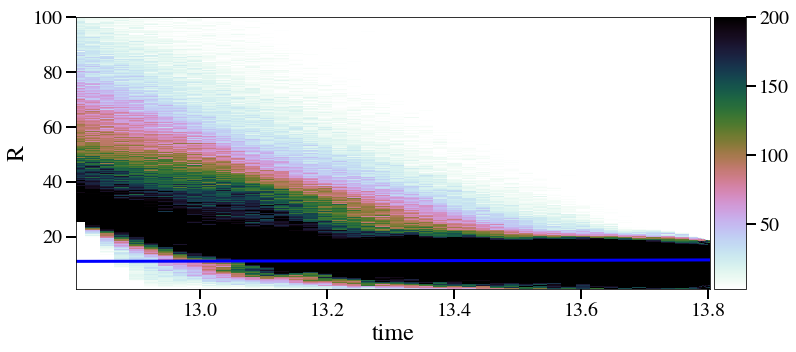

In [25]:
%matplotlib inline

fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'time',
    'R',
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=200 ),
    cmap = cm.cubehelix_r,
#     y_scale = 'log',
    y_range = [ 1., 100. ],
    x_range = x_range,
    n_bins_y = 512,
#     conditional_y = True,
    x_edges = t_bins,
)

ax.plot(
    w.get_data( 'time' )[:w.r_gal.size],
    w.r_gal,
    color = 'blue',
    linewidth = 3,
)

Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.


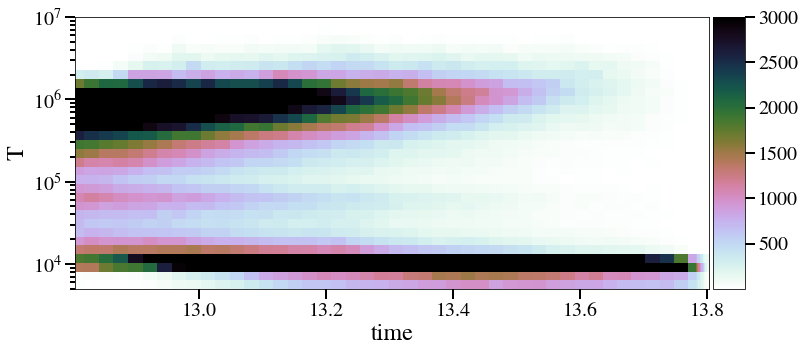

In [26]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'time',
    'T',
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=3000 ),
    y_scale = 'log',
    cmap = cm.cubehelix_r,
    y_range = [ 5e3, 1e7 ],
    x_range = x_range,
    x_edges = t_bins,
    n_bins_y = 32,
)

Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.


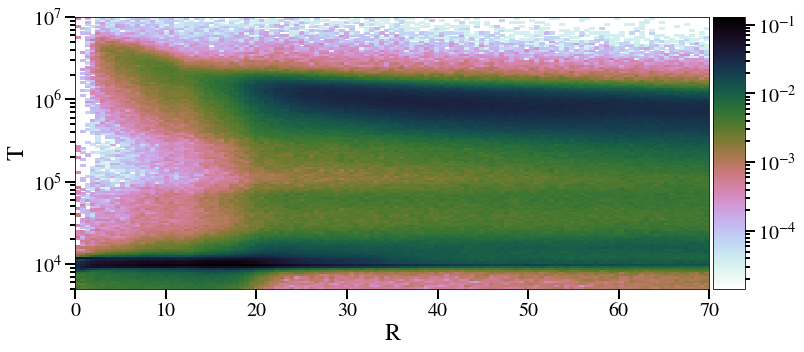

In [27]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'R',
    'T',
    ax = ax,
    x_data_args = { 'tile_data': True },
#     z_scale = plt_colors.Normalize( vmin=3, vmax=1000 ),
    y_scale = 'log',
    cmap = cm.cubehelix_r,
    x_range = [ 0, 70 ],
    y_range = [ 5e3, 1e7 ],
#     x_range = x_range,
    n_bins_x = 128,
    n_bins = 128,
    conditional_y = True,
)

Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.


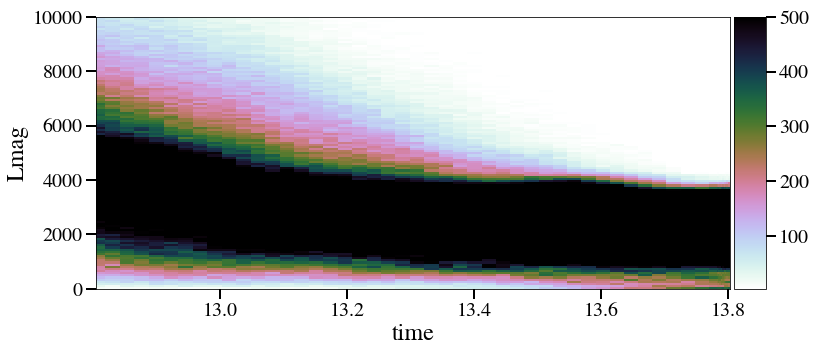

In [28]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

y_data = w.get_selected_data( 'Lmag' ) / w.get_selected_data( 'M' )

w_plotter.histogram2d(
    'time',
    'Lmag',
    y_data = y_data,
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=500 ),
#     y_scale = 'log',
    y_range = [ 0, 10000 ],
    x_range = x_range,
    x_edges = t_bins,
    cmap = cm.cubehelix_r,
)

Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.


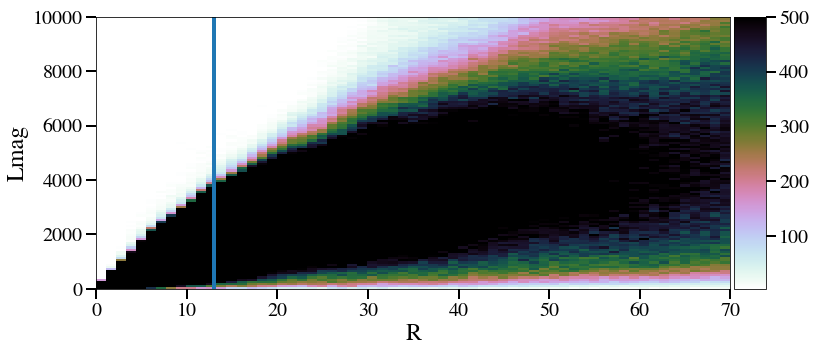

In [29]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

y_data = w.get_selected_data( 'Lmag' ) / w.get_selected_data( 'M' )

w_plotter.histogram2d(
    'R',
    'Lmag',
    y_data = y_data,
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=500 ),
#     y_scale = 'log',
    y_range = [ 0, 10000 ],
    x_range = [ 0, 70 ],
    n_bins_x = 64,
    cmap = cm.cubehelix_r,
)

ax.axvline(
    13,
    linewidth = 4,
)

Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.


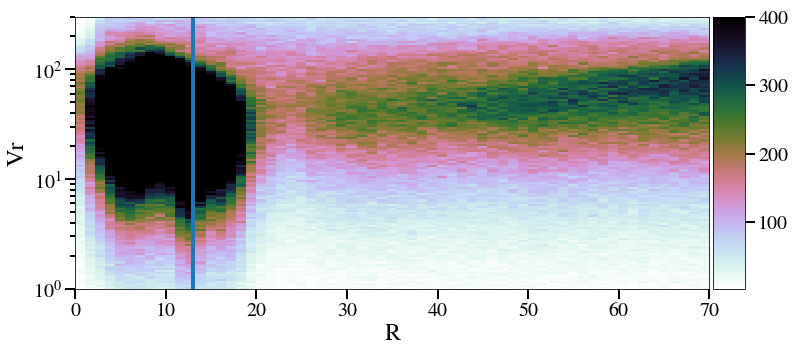

In [30]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'R',
    'Vr',
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=400 ),
    y_scale = 'log',
    y_range = [ 1., 300 ],
    x_range = [ 0, 70 ],
    n_bins_x = 64,
    cmap = cm.cubehelix_r,
)

ax.axvline(
    13,
    linewidth = 4,
)

Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.


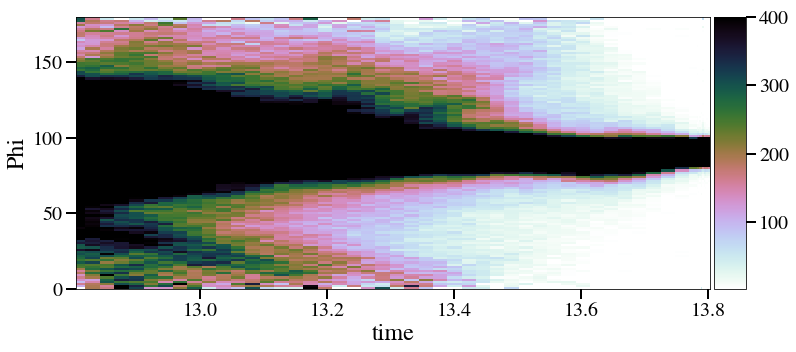

In [31]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'time',
    'Phi',
    weight_key = '1/sin',
    weight_data = 1. / np.sin( w.get_selected_data( 'Phi')*np.pi/180. ),
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=400 ),
#     y_scale = 'log',
#     y_range = [ 1e3, 1e7 ],
    x_range = x_range,
    x_edges = t_bins,
#     n_bins = 16,
    cmap = cm.cubehelix_r,
)

Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.


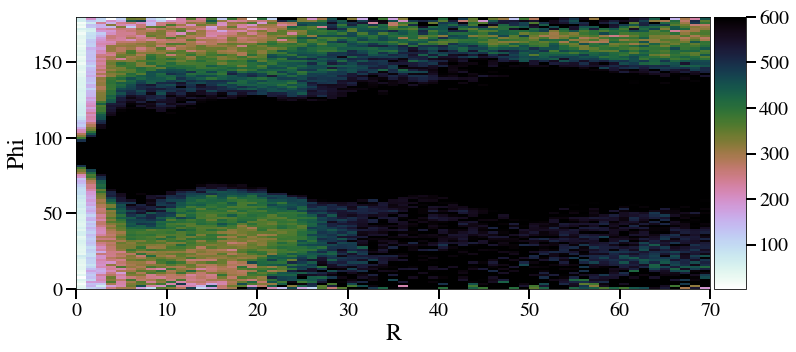

In [32]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'R',
    'Phi',
    weight_key = '1/sin',
    weight_data = 1. / np.sin( w.get_selected_data( 'Phi')*np.pi/180. ),
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=600 ),
#     y_scale = 'log',
#     y_range = [ 1e3, 1e7 ],
    x_range = [ 0, 70 ],
    n_bins_x = 64,
#     n_bins = 16,
    cmap = cm.cubehelix_r,
)

Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.


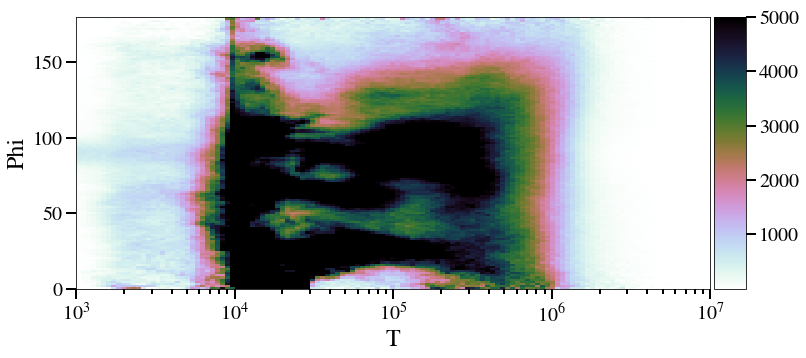

In [33]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'T',
    'Phi',
    weight_key = '1/sin',
    weight_data = 1. / np.sin( w.get_selected_data( 'Phi')*np.pi/180. ),
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=5000 ),
    x_scale = 'log',
    x_range = [ 1e3, 1e7 ],
#     n_bins_x = 64,
#     n_bins = 16,
    cmap = cm.cubehelix_r,
)

In [34]:
w.data_masker.clear_masks()

Attribute data_masker not found in plotting object. Checking data object.


## Pathline Plots

Attribute get_data not found in plotting object. Checking data object.
Attribute n_particles not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.


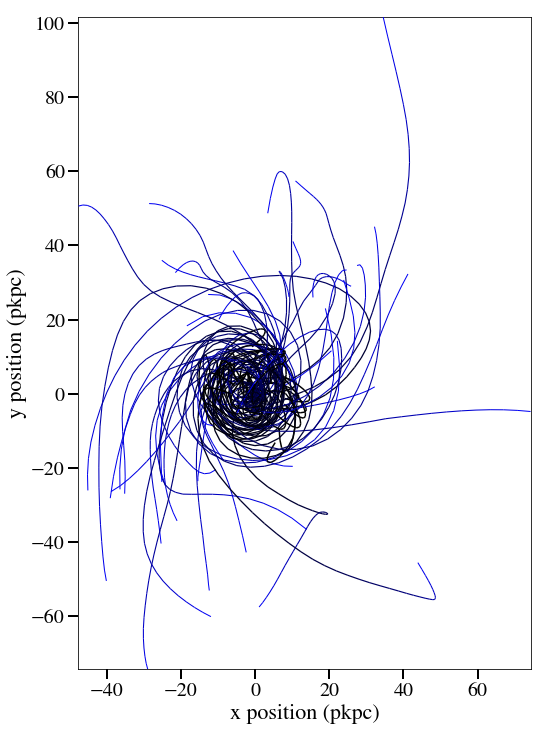

In [35]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

w_plotter.plot_streamlines(
#     classification = 'is_selected',
#     classification_ind = ind,
    ax = ax,
    start_ind = ind,
    end_ind = 'time_based',
    t_end = t_window,
    sample_size = 50,
    sample_selected_interval = False,
    x_data_kwargs = { 'tile_data': True, 'smooth_data' : True, 'smoothing_window_length' : 21 },
    y_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 21 },
    color = 'black',
    fade_color = 'blue',
    min_fade_linewidth = 1,
)

ax.set_aspect( 'equal' )

Attribute get_data not found in plotting object. Checking data object.
Attribute n_particles not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.
Attribute get_selected_data not found in plotting object. Checking data object.


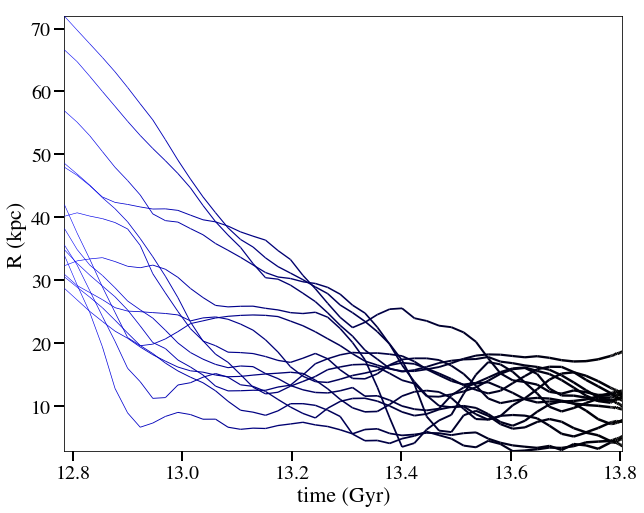

In [36]:
w_plotter.plot_streamlines(
    x_key = 'time',
    y_key = 'R',
    start_ind = ind,
    end_ind = 'time_based',
    t_end = t_window,
    sample_size = 15,
    sample_selected_interval = False,
    x_data_kwargs = {
        'tile_data': True,
        'smooth_data' : False,
        'smoothing_window_length' : 21,
    },
    y_data_kwargs = {
        'smooth_data' : False,
        'smoothing_window_length' : 21,
    },
    color = 'black',
    fade_color = 'blue',
    min_fade_linewidth = 0.5,
    linewidth = 3,
    x_label = 'time (Gyr)',
    y_label = 'R (kpc)',
)

In [53]:
def get_RMLt_at_Tcool( w ):
    
    w.data_masker.clear_masks()
    w.data_masker.mask_data( 'PType', data_value=0 )

    # Median and interval stats
    logT = np.log10( w.get_selected_data( 'T', compress=False ) )#[:,ind:ind+n_snaps+1]
    R = w.get_selected_data( 'R', compress=False )#[:,ind:ind+n_snaps+1]
    L = w.get_selected_data( 'Lmag', compress=False )#[:,ind:ind+n_snaps+1]
    M = w.get_selected_data( 'M', compress=False )#[:,ind:ind+n_snaps+1]

    logT_med = np.nanmedian( logT, axis=0 )
    R_med = np.nanmedian( R, axis=0 )

    logT_low = np.nanpercentile( logT, 16, axis=0 )
    logT_high = np.nanpercentile( logT, 84, axis=0 )

    R_low = np.nanpercentile( R, 16, axis=0 )
    R_high = np.nanpercentile( R, 84, axis=0 )

    inds = []
    for logT_arr in logT:

        ind_ = -1
        for i in range( logT_arr.size ):
            if logT_arr[i] > 5.:
                ind_ = i
                break

        inds.append( ind_ )

    inds = np.array( inds )

    R_at_Tcool = np.array( [ R[i, ind] for i, ind in enumerate( inds ) ] )
    M_at_Tcool = np.array( [ M[i, ind] for i, ind in enumerate( inds ) ] )
    L_at_Tcool = np.array( [ L[i, ind] for i, ind in enumerate( inds ) ] )

    t_at_Tcool = np.array( [ t[ind] for ind in inds ] )
    
    return R_at_Tcool, M_at_Tcool, L_at_Tcool, t_at_Tcool

In [60]:
RMLt_at_Tcool = {}
for sim_name_j, w_j in w_set.items():
    
    print( 'Calculating values at T=1e5K for {}'.format( sim_name_j ) )
    
    RMLt_at_Tcool[sim_name_j] = get_RMLt_at_Tcool( w_j.data_object )

Calculating values at T=1e5K for m12i_md


Calculating values at T=1e5K for m12b_md
Calculating values at T=1e5K for m12m
Calculating values at T=1e5K for m12f


(0.19912772, 13.804038)

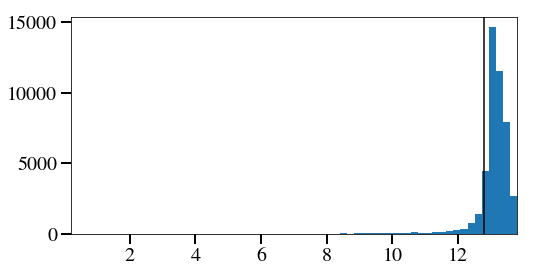

In [43]:
fig = plt.figure( figsize=(8, 4 ), facecolor='w' )
ax = plt.gca()

ax.hist(
    t_at_Tcool,
    bins = np.linspace( t.min(), t.max(), 64 ),
)

ax.axvline(
    12.8,
    color = 'k',
)

ax.set_xlim( t.min(), t.max() )
# ax.set_xscale( 'log' )

In [44]:
j_data = np.load( '../data/for_Zach.npz' )

In [48]:
def find_q_level( counts, q, start=1 ):
    
    tot = counts.sum()
    def fn_to_minimize( level ):
        contained = counts[counts>level].sum()
        return ( contained/tot - q/100. )**2.
    result = scipy.optimize.minimize( fn_to_minimize, start, method='Powell' )
        
    print( 'Found contour {} to within {}'.format( q, result.fun ) )
    assert result.fun < 0.01
    
    return result.x

In [64]:
ax.get_children()[0]

Plotting contour for m12i_md
Found contour 90 to within 3.001980721660705e-07
Found contour 50 to within 2.031891754547641e-05
Plotting contour for m12b_md
Found contour 90 to within 3.9949381425928837e-10
Found contour 50 to within 2.197493404692681e-06
Plotting contour for m12m
Found contour 90 to within 8.051147461033758e-08
Found contour 50 to within 4.396191420286142e-05
Plotting contour for m12f
Found contour 90 to within 2.4146736590063093e-06
Found contour 50 to within 9.145179290493274e-06
File saved at ../figures/j_vs_rcondense.png


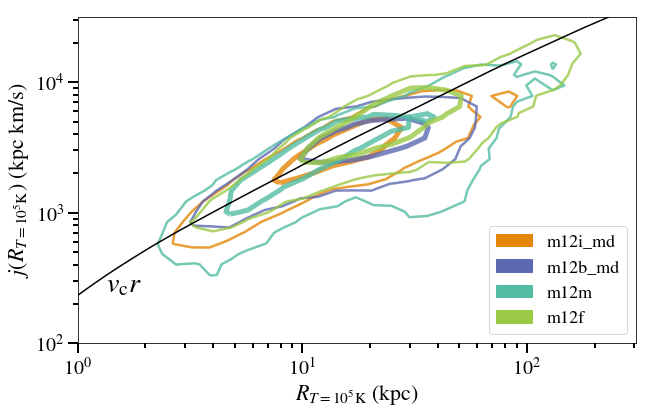

In [96]:
fig = plt.figure( figsize=(10, 6 ), facecolor='w' )
ax = plt.gca()

color_objects = []
labels = []
for j, (sim_name_j, w_j) in enumerate( w_set.items() ):
    
    w_j = w_j.data_object
    
    print( 'Plotting contour for {}'.format( sim_name_j ) )
    
    R_at_Tcool, M_at_Tcool, L_at_Tcool, t_at_Tcool = RMLt_at_Tcool[sim_name_j]
    
    # Make the histogram
    counts, xbins, ybins, image = ax.hist2d(
        R_at_Tcool,
        L_at_Tcool / M_at_Tcool,
        bins = [ np.logspace( 0., np.log10( w_j.r_vir[snum] ), 32 ), np.logspace( 2., 4.5, 32 ) ],
        cmap = cm.cubehelix_r,
    #     norm = plt_colors.LogNorm(),
    )

    # Contour plot grid
    logxbins = np.log10(xbins)
    xbin_centers = 10.**( logxbins[:-1] + 0.5 * ( logxbins[1] - logxbins[0] ) ) 
    logybins = np.log10(ybins)
    ybin_centers = 10.**( logybins[:-1] + 0.5 * ( logybins[1] - logybins[0] ) ) 
    meshed_xs, meshed_ys = np.meshgrid( xbin_centers, ybin_centers )

    # Contour plot
    percentile_levels = [ 90, 50, ]
    color = palettable.cartocolors.qualitative.Vivid_4.mpl_colors[j]
    levels = [ find_q_level( counts, q, start=1, ) for q in percentile_levels ]
    CS = ax.contour(
        meshed_xs, meshed_ys,
        counts.transpose(),
        extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
        linewidths = [ 2.5, 5, ],
        levels = levels,
        colors = [ color, ]*len( levels ),
        alpha = 0.8,
    )
    
    # For legend
    color_object = matplotlib.patches.Rectangle(                         
        (0, 0),                                                          
        1,                                                               
        1,                                                               
        fc = color,                                 
        ec = color,                                 
    )
    color_objects.append( color_object )                                 
    labels.append( sim_name_j )    

#     ax.clabel( CS, levels )

# Don't actually plot the histograms
for child in ax.get_children():
    if isinstance( child, matplotlib.collections.QuadMesh ):
        child.remove()

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )
# ax.set_xlim( 0, w.r_vir[snum] )
# ax.set_ylim( 1e2, 3e4 )

# ax.scatter(
#     R_at_Tcool,
#     L_at_Tcool / M_at_Tcool, 
#     s = 1,
#     alpha = 0.5,
# )

ax.plot(
    j_data['r'],
    j_data['r'] * j_data['vc'],
    color = 'k',
)

# j_data_ind = 245
j_data_ind = 65
ax.annotate(
    s=r'$v_{\rm c}r$',
    xy=( j_data['r'][j_data_ind], ( j_data['r'] * j_data['vc'] )[j_data_ind],),
    xytext=(10,-10),
    xycoords='data',
    textcoords='offset points',
    fontsize=28,
)

ax.legend(
    color_objects,
    labels,
    prop={'size': 18},
    loc = 'lower right',
)

ax.set_xlabel( r'$R_{T=10^5 {\rm K}}$ (kpc)', fontsize=22 )
ax.set_ylabel( r'$j(R_{T=10^5 {\rm K}})$ (kpc km/s)', fontsize=22 )

plotting.save_fig(
    out_dir = '../figures',
    save_file = 'j_vs_rcondense.png',
    fig = fig,
)

In [ ]:
w.data_masker.clear_masks()

In [ ]:
np.random.seed( 6 )

fig = plt.figure( figsize=(12, 11), facecolor='w' )
ax = plt.gca()

gs = gridspec.GridSpec(6, 1)

gs.update( hspace=0.001 )

ax1 = plt.subplot(gs[:2,0])

ax1.hist(
    R_at_Tcool,
    bins = np.linspace( 0., 0.5*w.r_vir[snum], 64 ),
)

# ax.axvline(
#     np.median( R_at_Tcool ),
#     color = 'k',
# )

ax1.axvline(
    w.r_gal[0],
    color = 'k',
    linestyle = '--',
    linewidth = 3,
)
ax1.axvline(
    0.1 * w.r_vir[snum],
    color = 'k',
    linestyle = '--',
    linewidth = 3,
)
ax1.axvline(
    w.r_vir[snum],
    color = 'k',
    linestyle = '--',
    linewidth = 3,
)

ax1.set_xlim( 0, 100. )

ax1.set_xlabel( r'$R_{\rm{condense}}$ (kpc)', fontsize=22, labelpad=10 )
ax1.xaxis.set_label_position( 'top' )
ax1.set_ylabel( 'count', fontsize=22, )

ax1.tick_params( axis='x', top=True, labeltop=True, bottom=False, labelbottom=False )

ax1.annotate(
    s='Accreted Gas',
    xy=(1,1),
    xycoords='axes fraction',
    xytext=(-10,-10),
    textcoords='offset points',
    ha = 'right',
    va = 'top',
    fontsize = 22,
)

ax2 = plt.subplot(gs[2:,0])

w_plotter.plot_streamlines(
    ax = ax2,
    x_key = 'R',
    y_key = 'logT',
    start_ind = ind,
    end_ind = 'time_based',
    t_end = 5.,
    sample_size = 30,
    sample_selected_interval = False,
    x_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 7 },
    y_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 7 },
    color = 'black',
    fade_color = 'black',
    min_fade_linewidth = 0.5,
#     fade_streamlines = False,
#     line_features = gas_to_star_line_features,
    linewidth = 1,
    x_label = 'R (kpc)',
    y_label = 'logT (K)',
#     y_scale = 'log',
    x_range = [ 0, 100. ],
    y_range = [ 3.5, 6.9 ],
#     y_floor = 10.**3.8,
)

# # In space
# w_plotter.statistic_and_interval(
#     ax = ax,
#     x_key = 'R',
#     y_key = 'logT',
#     fix_invalid = True,
#     alpha = 0.25,
#     bins = np.linspace( 0., w.r_vir[snum]*0.2, 64 ),
# )

# # Time
# ax.plot(
#     R_med,
#     logT_med,
#     linewidth = 3,
#     color = 'b',
# )
# ax.fill_between(
#     R_med,
#     logT_low,
#     logT_high,
#     color = 'b',
#     alpha = 0.25,
# )

ax2.axvline(
    w.r_vir[snum]*0.1,
    color = 'k',
    linestyle = '--',
    linewidth = 3,
)

plotting.save_fig(
    out_dir = '../figures',
    save_file = 'rcondense_and_tracks.pdf',
    fig = fig,
)

In [ ]:
t_tphase = ( t[:,np.newaxis] - t[inds] ).transpose()

In [ ]:
w.data_masker.clear_masks()
w.data_masker.mask_data( 'PType', data_value=0 )
phi = w.get_selected_data( 'Phi', compress=False )

In [ ]:
fig = plt.figure( figsize=(10, 6 ), facecolor='w' )
ax = plt.gca()

ax.hist2d(
    t_tphase.flatten(),
    phi.flatten(),
#     weight_key = '1/sin',
#     weight_data = 1. / np.sin( phi.flatten()*np.pi/180. ),
    bins = [ np.linspace( -.25, .25, 16 ), np.linspace( 0., 180., 64 ) ],
    cmap = cm.cubehelix_r,
    norm = plt_colors.LogNorm(),
)

ax.axvline(
    0.,
    color = 'k',
    linestyle = '--',
    linewidth = 3,
)
ax.axhline(
    90.,
    color = 'k',
    linestyle = '--',
    linewidth = 3,
)

ax.set_xlabel( r'$t - t_{\rm{condense}}$ (Gyr)', fontsize=22 )
ax.set_ylabel( r'$\theta$ ($\degree$)', fontsize=22 )

In [ ]:
t_half_width = 0.25
dt = 0.025
t_tphase_centers = np.arange( -t_half_width, t_half_width + 0.01, dt)
t_tphase_centers = np.array([ -0.2, -0.1, 0., 0.1, 0.2 ])

In [ ]:
phi_flat = phi.flatten()
t_tphase_flat = t_tphase.flatten()

In [ ]:
phi_dists = []
for i, center in enumerate( t_tphase_centers ):
    bin_low = center - dt / 2.
    bin_high = center + dt / 2.
    in_bin = ( t_tphase_flat > bin_low ) & ( t_tphase_flat < bin_high )
    hist, bin_edges = np.histogram(
        np.cos( phi_flat[in_bin] * np.pi / 180 ),
        bins = np.linspace( -1., 1., 64 ),
        density = True,
    )
    phi_dists.append( hist )

In [ ]:
bin_centers = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

In [ ]:
labeled_is = np.arange( 5 )

In [ ]:
fig = plt.figure( figsize=(10, 6 ), facecolor='w' )
ax = plt.gca()

z_max = t_tphase_centers.max()
z_min = t_tphase_centers.min()
for i, phi_dist in enumerate( phi_dists ):
    
    z_width = z_max - z_min
    color_value = ( t_tphase_centers[i] - z_min )/z_width
    color = palettable.cartocolors.diverging.Geyser_4_r.mpl_colormap( color_value )
    
    if i in labeled_is:
        if np.isclose( t_tphase_centers[i], 0. ):
            t_tphase_centers[i] = 0
        label = r'$t - t_{\rm condense}$=' + ' {:.3g} Gyr'.format( t_tphase_centers[i] )
    else:
        label = None
    
    ax.plot(
        bin_centers,
        phi_dist, #/ (np.pi / 180. / 2. * np.sin( bin_centers * np.pi/180. ) ),
        linewidth = 3,
        color = color,
        label = label,
    )
    
ax.axhline(
    0.5,
    color = '.2',
    linestyle = '-',
    linewidth = 1.5,
)
ax.axvline(
    0,
    color = '.2',
    linestyle = '-',
    linewidth = 1.5,
)

ax.legend(
    prop={'size': 18},
    loc = 'upper right',
)
    
ax.set_xlim( -1, 1 )
ax.set_ylim( 0, 4 )

ax.set_xlabel( r'$\cos\ \theta$', fontsize=22 )
ax.set_ylabel( r'PDF$\ (\cos\ \theta$)', fontsize=22 )

plotting.save_fig(
    out_dir = '../figures',
    save_file = 'theta_vs_t.pdf',
    fig = fig,
)